TensorFlow 1.x selected.


Using TensorFlow backend.


(791, 250, 250, 3)
(791,)
(784, 250, 250, 3)
(784,)


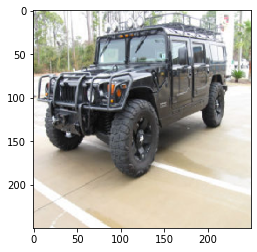

(791, 250, 250, 3)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

553467904/553467096 [==============================] - 13s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)   

In [0]:
# -*- coding: utf-8 -*-

%tensorflow_version 1.x
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD, Adam
from keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16



batch_size = 64
num_classes = 20
epochs = 25



#### LOAD AND TRANSFORM

## Download: ONLY ONCE!
os.system('wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz')
os.system('tar xvzf data.tgz')
#####


# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

## View some images
plt.imshow(x_train[2,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255


## Labels
y_train=y_train-1

y_test=y_test-1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

###########################################################
print(x_train.shape)


############################################################

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    #return .001
    if epoch < 300:
        return .001
    else:
      return 0.0001

set_lr = LRS(scheduler)


#Cargamos el modelo vgg16

modelVGG = VGG16(include_top=True, weights='imagenet', input_tensor=Input(shape=(250, 250, 3)), input_shape=None, pooling=None, classes=1000)
for layer in modelVGG.layers:
  layer.trainable  = False

from keras.applications.vgg16 import decode_predictions
modelVGG.summary()
# convert the probabilities to class labels
label = decode_predictions(modelVGG.predict(x_test))
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))
#print()


#############################
###      BILINEAR        ####
#############################

def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])		# Einstein Notation  [batch,31,31,depth] x [batch,31,31,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	        # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,31*31)								  # Divide by feature map size [sizexsize]

  y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))		# Take signed square root of phi_I
  z_l2 = tf.nn.l2_normalize(y_ssqrt, dim=1)								              # Apply l2 normalization
  return z_l2



conv=modelVGG.get_layer('block4_conv3') 
d1=Dropout(0.5)(conv.output)   ## Why??
d2=Dropout(0.5)(conv.output)   ## Why??

x = Lambda(outer_product, name='outer_product')([d1,d2])

predictions=Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=modelVGG.input, outputs=predictions)
opt = Adam(lr=0.1, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    
  
model.summary()

datagen = ImageDataGenerator(
  width_shift_range=0.3,
  height_shift_range=0.3,
  rotation_range=25,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            verbose=1)

In [0]:
for layer in model.layers:
  layer.trainable  = True
opt = SGD(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            
                            verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
13/12 [===============================] - 17s 1s/step - loss: 0.0613 - accuracy: 0.9861 - val_loss: 1.4130 - val_accuracy: 0.6224
Epoch 2/25
13/12 [===============================] - 13s 1s/step - loss: 0.0567 - accuracy: 0.9861 - val_loss: 1.4333 - val_accuracy: 0.6301
Epoch 3/25
13/12 [===============================] - 13s 1s/step - loss: 0.0505 - accuracy: 0.9861 - val_loss: 1.4497 - val_accuracy: 0.6263
Epoch 4/25
13/12 [===============================] - 13s 1s/step - loss: 0.0472 - accuracy: 0.9861 - val_loss: 1.3797 - val_accuracy: 0.6390
Epoch 5/25
13/12 [===============================] - 13s 1s/step - loss: 0.0616 - accuracy: 0.9848 - val_loss: 1.4281 - val_accuracy: 0.6327
Epoch 6/25
13/12 [===============================] - 14s 1s/step - loss: 0.0336 - accuracy: 0.9924 - val_loss: 1.3836 - val_accuracy: 0.6492
Epoch 7/25
13/12 [===============================] - 13s 999

In [0]:
opt = SGD(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            
                            verbose=1)

Epoch 1/25
13/12 [===============================] - 15s 1s/step - loss: 0.0423 - accuracy: 0.9886 - val_loss: 1.4204 - val_accuracy: 0.6505
Epoch 2/25
13/12 [===============================] - 13s 986ms/step - loss: 0.0267 - accuracy: 0.9937 - val_loss: 1.4218 - val_accuracy: 0.6505
Epoch 3/25
13/12 [===============================] - 13s 995ms/step - loss: 0.0323 - accuracy: 0.9912 - val_loss: 1.4270 - val_accuracy: 0.6492
Epoch 4/25
13/12 [===============================] - 13s 994ms/step - loss: 0.0350 - accuracy: 0.9924 - val_loss: 1.4208 - val_accuracy: 0.6518
Epoch 5/25
13/12 [===============================] - 13s 999ms/step - loss: 0.0278 - accuracy: 0.9937 - val_loss: 1.4241 - val_accuracy: 0.6543
Epoch 6/25
13/12 [===============================] - 13s 996ms/step - loss: 0.0214 - accuracy: 0.9949 - val_loss: 1.4260 - val_accuracy: 0.6543
Epoch 7/25
13/12 [===============================] - 13s 998ms/step - loss: 0.0315 - accuracy: 0.9912 - val_loss: 1.4323 - val_accuracy: 0.